In [1]:
import matplotlib.pyplot as plt
import numpy
import matplotlib
import matplotlib.colors as colors
#from partials import zintegral_fast, restrate_Ia, sigOM0sqinv
from matplotlib import ticker, cm
from astropy.cosmology import FlatLambdaCDM
import scipy.integrate as integrate
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import sys
sys.path.insert(1, '/Users/akim/project/PeculiarVelocity/doc/src/')

from partials import zintegral_fast, restrate_Ia, sigOM0sqinv

In [2]:
#Number of SNe out to redshift
def N_SN_yr(zmax):
    OmegaM0 = 0.28
    cosmo = FlatLambdaCDM(H0=100, Om0=OmegaM0)
    ans = integrate.quad(lambda x: cosmo.differential_comoving_volume(x).value/(1+x), 0, zmax)
    return(ans[0]*restrate_Ia*4*numpy.pi)

In [3]:
# Manips
import pandas as pd
df = pd.DataFrame(index='ZTF Altsched Baseline TAIPAN'.split(),columns = 'emu N zmax date'.split())
df.loc['ZTF-II','emu'] = 0.12
df.loc['ZTF-II','zmax'] = 0.09
df.loc['ZTF-II', 'N'] = 6000
df.loc['ZTF-II','date'] = 2023

df.loc['ZTF-IIb','emu'] = 0.12
df.loc['ZTF-IIb','zmax'] = 0.08
df.loc['ZTF-IIb', 'N'] = 3000
df.loc['ZTF-IIb','date'] = 2023

df.loc['LSST','emu'] = 0.12
df.loc['LSST','zmax'] = 0.08
df.loc['LSST', 'N'] = 3000
df.loc['LSST','date'] = 2031

df.loc['ZTF-I','emu'] = 0.12
df.loc['ZTF-I','zmax'] = 0.08
df.loc['ZTF-I', 'N'] = 800
df.loc['ZTF-I','date'] = 2020

df.loc['SNGrowth (Traditional)','emu']=0.12
df.loc['SNGrowth (Traditional)','zmax']=0.08
df.loc['SNGrowth (Traditional)','N'] = 4000
df.loc['SNGrowth (Traditional)','date'] = 2023

df.loc['SNGrowth (PV optimized)','emu']=0.08
df.loc['SNGrowth (PV optimized)','zmax']=0.08
df.loc['SNGrowth (PV optimized)','N'] = 4000
df.loc['SNGrowth (PV optimized)','date'] = 2023


df.loc['Altsched', 'emu'] = 0.12
df.loc['Altsched', 'N'] = 125000
df.loc['Altsched', 'zmax'] = 0.25
df.loc['Altsched','date'] = 2032
df.loc['Baseline','N'] = 20000
df.loc['Baseline','emu'] = 0.12
df.loc['Baseline','zmax'] = 0.2
df.loc['Baseline','date'] = 2032
df.loc['TAIPAN','emu'] = 0.45
df.loc['TAIPAN','zmax'] = 0.1
df.loc['TAIPAN', 'N'] = 50000
df.loc['TAIPAN','date'] = 2022

In [4]:
def show_marker(name, **kwargs):
   x = numpy.log10(df.loc[name,'N'])
   y = df.loc[name,'emu']
   p = ax.plot(x,y, **{**dict(ls="None", marker="o"),**kwargs})
   return x,y

In [18]:
#ZTF2
skyfrac=0.5
zmax=0.09
skyarea = skyfrac*4*numpy.pi

#durations = numpy.arange(1,12.1,5)
logdurations = numpy.arange(0.4,1.61,1.2/10)
durations = 10**(logdurations)
sigm_Ias = numpy.arange(0.05,0.501,0.45/10)
X, Y = numpy.meshgrid(numpy.log10(durations*skyarea/4/numpy.pi*N_SN_yr(zmax)), sigm_Ias)

In [6]:
var =[]
for sigm_Ia in sigm_Ias:
    v_=[]

    for duration in durations:
        f00,f11,f10, f02,f12,f22 = zintegral_fast(zmax,None,duration,sigm_Ia,restrate_Ia)
        v_.append(numpy.linalg.inv(numpy.array([[f00,f10,f02],[f10,f11,f12],[f02,f12,f22+sigOM0sqinv]]))[0,0])

    var.append(numpy.array(v_)*2*3.14/skyfrac)

In [2]:
# Sample variance limit
f00,f11,f10, f02,f12,f22 = zintegral_fast(0.1,None,10,0.12,restrate_Ia)
limit = numpy.linalg.inv(numpy.array([[f00,f10,f02],[f10,f11,f12],[f02,f12,f22+sigOM0sqinv]]))[0,0]
limit = limit*2*3.14/skyfrac
print(numpy.sqrt(limit))

NameError: name 'zintegral_fast' is not defined

In [3]:
#LSST North and South
#skyfrac_lsst = 0.5
#zmax_lsst=0.2
#duration_lsst=10

#sigm_Ia_lsst=0.08
#f00,f11,f10, f02,f12,f22 = zintegral_fast(zmax_lsst,None,duration_lsst,sigm_Ia_lsst,restrate_Ia)
#LSST_08 = numpy.linalg.inv(numpy.array([[f00,f10,f02],[f10,f11,f12],[f02,f12,f22+sigOM0sqinv]]))[0,0]

#sigm_Ia_lsst=0.12
#f00,f11,f10, f02,f12,f22 = zintegral_fast(zmax_lsst,None,duration_lsst,sigm_Ia_lsst,restrate_Ia)
#LSST_12 = numpy.linalg.inv(numpy.array([[f00,f10,f02],[f10,f11,f12],[f02,f12,f22+sigOM0sqinv]]))[0,0]

#LSST_08 = LSST_08*2*3.14/skyfrac_lsst
#LSST_12 = LSST_12*2*3.14/skyfrac_lsst

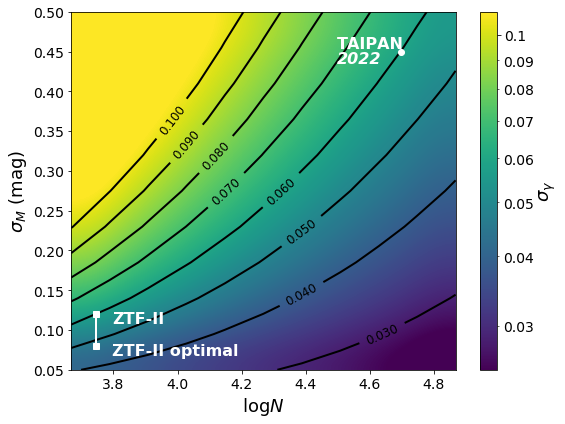

In [32]:
#plots
plt.rcParams["figure.figsize"] = (8,6)
Z = numpy.sqrt(var)
levels = numpy.arange(0.0,.1001,0.01)
fig, ax = plt.subplots()
cs = ax.imshow(Z,norm=colors.LogNorm(),origin='lower',interpolation='bicubic',aspect='auto',
               extent=[X.min(),X.max(), Y.min(), Y.max()],vmin=0.025,vmax=0.11)#, cmap=cm.PuBu_r)

cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'$\sigma_\gamma$', fontsize=18)
cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
cbar.ax.yaxis.set_minor_formatter(ScalarFormatter())
cbar.ax.tick_params(labelsize=14,which='both')

cset2 = ax.contour( Z, levels, colors='k',extent=[X.min(), X.max(), Y.min(), Y.max()])
ax.clabel(cset2, inline=True, fontsize=12)

ax.set_xlabel(r'$\log{N}$', fontsize=18)
ax.set_ylabel(r'$\sigma_M$ (mag)', fontsize=18)
ax.tick_params(labelsize=14)

# ZTF-II
name = "ZTF-II"
color = "w"
# x,y = show_marker(name, color=color, marker="s")
logN = numpy.log10(3*skyarea/4/numpy.pi*N_SN_yr(zmax)) # 3-years 

ax.plot([logN,logN],[0.08,0.12],color=color)
p = ax.plot(logN,0.08, **{**dict(ls="None", marker="s",color=color)})
p = ax.plot(logN,0.12, **{**dict(ls="None", marker="s",color=color)})
ax.text(logN+.05,0.12-.015,name, fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left", fontsize=16)
ax.text(logN+.05,0.08-.015,name+" optimal", fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left", fontsize=16)
#ax.text(logN+.1,0.1,df.loc[name,'date'], fontdict=dict(color = color ,weight = 'bold'), 
#           va="top", ha="left", style='italic', fontsize="small")

name = "TAIPAN"
color = "w"
x,y = show_marker(name, color=color)
ax.text(x-.2,y,name, fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left", fontsize=16)
ax.text(x-.2,y,df.loc[name,'date'], fontdict=dict(color = color ,weight = 'bold'), 
           va="top", ha="left", style='italic', fontsize=16)

# cset2 = ax.contour( Z, [numpy.sqrt(LSST_08),numpy.sqrt(LSST_12)], colors='red',extent=[X.min(), X.max(), Y.min(), Y.max()])
# ax.text(4.5,0.12, 'LSST optimal', fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left")
# ax.text(4.4+.3,0.25, 'LSST ', fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left")


#name = 'LSST + North'
#print (numpy.sqrt(LSST_08),numpy.sqrt(LSST_12))
#cset2 = ax.contour( Z, [numpy.sqrt(LSST_08),numpy.sqrt(LSST_12)], colors='red',extent=[X.min(), X.max(), Y.min(), Y.max()])
#ax.text(4.5,0.15, name, fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left")

#cset2 = ax.contour( Z, [limit], colors='red',extent=[X.min(), X.max(), Y.min(), Y.max()])

#print (numpy.sqrt(limit))
plt.tight_layout()
plt.savefig("surface1.pdf")

In [9]:
import pickle
pkl_file = open('surface.pkl', 'wb')
pickle.dump(var,pkl_file)
pkl_file.close()

In [101]:
print(Z.min())

0.026873130332692216


In [16]:
import pickle
pkl_file = open('surface.pkl', 'rb')
var  = pickle.load(pkl_file)
pkl_file.close()
#var=out[0]
#LSST_08=out[1]
#LSST_12=out[2]

In [10]:
#LSST
skyfrac=0.5
duration = 10

zmaxs = numpy.arange(0.05,0.30001,0.25/10)
logzmaxs = numpy.arange(numpy.log10(0.05), numpy.log10(0.3)+0.001, numpy.log10(.3/0.05)/10)
zmaxs  = 10**logzmaxs
sigm_Ias = numpy.arange(0.05,0.151,0.1/10)
X, Y = numpy.meshgrid(zmaxs, sigm_Ias)

In [11]:
var =[]
for sigm_Ia in sigm_Ias:
    v_=[]

    for zmax in zmaxs:
        f00,f11,f10, f02,f12,f22 = zintegral_fast(zmax,None,duration,sigm_Ia,restrate_Ia)
        v_.append(numpy.linalg.inv(numpy.array([[f00,f10,f02],[f10,f11,f12],[f02,f12,f22+sigOM0sqinv]]))[0,0])

    var.append(numpy.array(v_)*2*3.14/skyfrac)

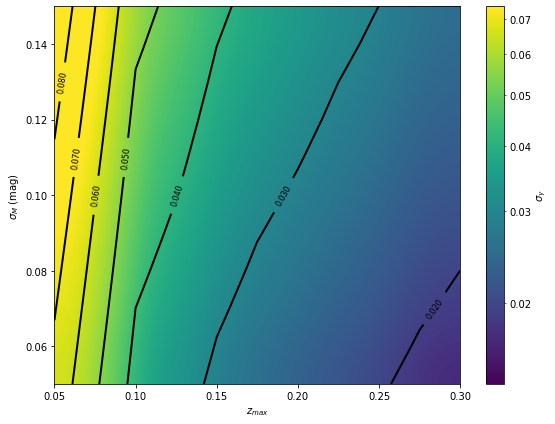

In [12]:
#plots
plt.rcParams["figure.figsize"] = (8,6)
Z = numpy.sqrt(var)
levels = numpy.arange(0.0,.1001,0.01)
fig, ax = plt.subplots()
cs = ax.imshow(Z,norm=colors.LogNorm(),origin='lower',interpolation='bicubic',aspect='auto',
               extent=[X.min(),X.max(), Y.min(), Y.max()],vmin=0.014,vmax=0.074)#, cmap=cm.PuBu_r)
#cs = ax.imshow(Z,origin='lower',interpolation='bicubic',aspect='auto',
#               extent=[X.min(),X.max(), Y.min(), Y.max()])#, cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'$\sigma_\gamma$')
cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
cbar.ax.yaxis.set_minor_formatter(ScalarFormatter())

cset2 = ax.contour( Z, levels, colors='k',extent=[X.min(), X.max(), Y.min(), Y.max()])
ax.clabel(cset2, inline=True, fontsize=8)

ax.set_xlabel(r'$z_{max}$')
ax.set_ylabel(r'$\sigma_M$ (mag)')

plt.tight_layout()
plt.savefig("surface2.pdf")

In [126]:
print (Z)

[[0.06716699 0.05140701 0.03636624 0.0323517  0.02735208 0.02435223
  0.0222915  0.02001321 0.01814436 0.01527185 0.013012  ]
 [0.06867829 0.05272685 0.03744259 0.03333091 0.0281911  0.02509339
  0.02296784 0.02064168 0.01877082 0.01596383 0.01377552]
 [0.07025546 0.05410368 0.0385678  0.03435473 0.02906943 0.02586808
  0.02367077 0.02128323 0.01939236 0.01661558 0.01447621]
 [0.07189373 0.05553274 0.03973749 0.03541909 0.02998374 0.02667407
  0.02439957 0.02194056 0.02001651 0.01724356 0.01513436]
 [0.07358893 0.05700992 0.04094783 0.03652036 0.03093084 0.02750883
  0.02515269 0.02261424 0.02064689 0.01785743 0.01576289]
 [0.07533737 0.05853163 0.04219533 0.03765521 0.03190768 0.02836974
  0.02592814 0.02330369 0.02128493 0.01846275 0.01636997]
 [0.07713569 0.06009462 0.04347682 0.03882054 0.03291133 0.02925416
  0.02672371 0.02400769 0.02193078 0.01906259 0.01696071]
 [0.07898081 0.06169593 0.04478932 0.04001352 0.03393905 0.03015955
  0.02753716 0.02472465 0.02258384 0.01965847 0.01

In [13]:
import pickle
pkl_file = open('surface2.pkl', 'wb')
pickle.dump(var,pkl_file)
pkl_file.close()

In [14]:
# ZTF and Taipan
skyfrac=0.5
zmax=0.09
skyarea = skyfrac*4*numpy.pi

f00,f11,f10, f02,f12,f22 = zintegral_fast(zmax,None,3,0.08,restrate_Ia)
dum=numpy.linalg.inv(numpy.array([[f00,f10,f02],[f10,f11,f12],[f02,f12,f22+sigOM0sqinv]]))[0,0]
print(numpy.sqrt(dum*2*3.14/skyfrac))

f00,f11,f10, f02,f12,f22 = zintegral_fast(zmax,None,3,0.12,restrate_Ia)
dum=numpy.linalg.inv(numpy.array([[f00,f10,f02],[f10,f11,f12],[f02,f12,f22+sigOM0sqinv]]))[0,0]
print(numpy.sqrt(dum*2*3.14/skyfrac))

0.04781964081070142
0.060052747332377754


0.0028527668088095368
